In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD



In [3]:
include("src/utils.jl")
include("src/expo_environment.jl")
include("src/raycaster.jl")
include("src/nb_1.jl");
include("src/nb_2.jl");

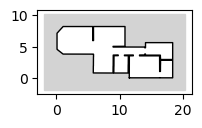

(187, 4)


In [4]:
env = load_env(2010)
println(size(env.segs))
plt.figure(figsize=(2,2)); plt.gca().set_aspect(1.);
draw_env!(env);

# Ground truth w/ old sensor model

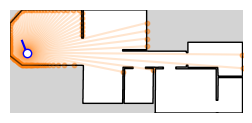

PyObject <matplotlib.collections.PathCollection object at 0x7faa690d2f90>

In [23]:
p0 = pose_prior(env)
old_sensor_args  = (fov=180, n=100, a_noise=1e-9, z_noise=1e-5, max_z=30.)
z0,a0 = s0 = sensor_model(p0, env, old_sensor_args...)

plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.); plt.gca().axis("off")
plt.xlim(env.bounds[1,:]...)
plt.ylim(env.bounds[2,:]...)
draw_env!(env)
draw_pose!(p0)
draw_sense!(s0, p0, s=10)

# Pose Inference

In [24]:
"""
    model(env, sensor_args)

Combines the new sensor model with the pose prior.
"""
@gen (static) function model(env::Env, sensor_args)
    fov, n, z_noise, max_z, drop_out = sensor_args
    
    pose  = @trace(pose_prior(env), :pose)
    sense = @trace(sensor_model_loosened(pose, env, fov, n, z_noise, max_z, drop_out), :sense)
    
    return pose, sense
end;

Gen.load_generated_functions();

In [27]:
obs = choicemap()
obs[:sense => :z] = z0

z_noise = 0.1
drop_out = 0.2

sensor_args  = (fov=180, n=100, z_noise=z_noise, max_z=30., drop_out=drop_out)


trs, ws, lml = Gen.importance_sampling(model, (env, sensor_args), obs, 10000);
perm = sortperm(ws)
trs = trs[perm];
ws = ws[perm];

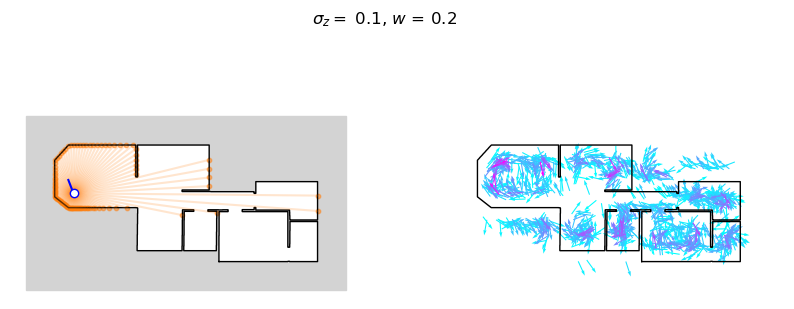

png/loc_wrt_noise_sig_0.1_w_0.2.png


In [68]:
xs = hcat([tr[:pose].x for tr in trs]...)
hds = hcat([tr[:pose].hd for tr in trs]...)
vs = vcat(cos.(hds), sin.(hds))

cm = plt.cm.get_cmap("cool")
q = quantile(ws, 0.9)

cs = clamp.(ws, q, 0.)
cs .-= min(cs...)
cs ./= max(cs...)

ind = ws .> q
cs′ = cs[ind]
xs′ = xs[:,ind]
vs′ = vs[:,ind]

fig, axs = plt.subplots(1,2,figsize=(10,4)); 

fig.suptitle("\$ \\sigma_z= \$ $(z_noise), \$w\$ = $(drop_out)")

axs[1].set_aspect(1.)
axs[1].axis("off")
draw_env!(env, ax=axs[1])
draw_pose!(p0, ax=axs[1])
draw_sense!(s0, p0, s=10, ax=axs[1])


axs[2].set_aspect(1.)
axs[2].axis("off")
draw_env!(env, ax=axs[2], zorder=1, wall="black", grass="w", floor="w", l=1)

axs[2].quiver(xs′[1,:], xs′[2,:], vs′[1,:], vs′[2,:], width=0.075,
    units="xy", scale_units="xy", scale=1/1.1, color=cm.(cs′))  

fname = "png/loc_wrt_noise_sig_$(z_noise)_w_$(drop_out).png"
println(fname)
plt.savefig(fname)